<a href="https://colab.research.google.com/github/BlancoAnna/DL--2025/blob/main/Problems%2011%20-%20Metric%20Learning/P11_Metric_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/dkaratzas/DL2022-23/blob/main/Problems%2010%20-%20Metric%20Learning/P10_Metric_Learning.ipynb)

# Metric Learning

In this practical, we will calculate 2-dimensional embeddings (so that we can easily visualise them) using different approaches: a classification network, a siamese network, and a triplet network. We will use FashionMNIST.

First some preliminary stuff. Apart from typical imports, we define also two functions that will help us later on to generate embeddings for all our data and to plot them in a 2D scatter plot.

In [1]:
import os
import random

import torch
from torch.optim import lr_scheduler
import torch.optim as optim

import numpy as np

import matplotlib.pyplot as plt

from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [2]:
fashion_mnist_classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(fashion_mnist_classes)


def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

## Import data

Import the FashionMNIST data and define datasets and data loaders.

In [3]:
mean, std = 0.28604059698879553, 0.35302424451492237

train_dataset = FashionMNIST('data', train=True, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((mean,), (std,))
                             ]))
test_dataset = FashionMNIST('data', train=False, download=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((mean,), (std,))
                            ]))

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.7MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 198kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.66MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 16.4MB/s]


In [4]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#If this cell fails you need to change the runtime of your colab notebook to GPU
# Go to Runtime -> Change Runtime Type and select GPU
assert torch.cuda.is_available(), "GPU is not enabled"

In [5]:
# Set up data loaders
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## The Embedding Network

To do the embedding always in the same manner, we will define the embedding part once, and then reuse it with different networks. The embedding we will use is a small CNN architecture, followed by a couple of FC layers that bring down the output to 2 dimensions (so that we can plot the results later).

In [6]:
class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()
        self.convnet = nn.Sequential(nn.Conv2d(1, 32, 5), nn.PReLU(),
                                     nn.MaxPool2d(2, stride=2),
                                     nn.Conv2d(32, 64, 5), nn.PReLU(),
                                     nn.MaxPool2d(2, stride=2))

        self.fc = nn.Sequential(nn.Linear(64 * 4 * 4, 256),
                                nn.PReLU(),
                                nn.Linear(256, 256),
                                nn.PReLU(),
                                nn.Linear(256, 2)
                                )

    def forward(self, x):
        output = self.convnet(x)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output

    def get_embedding(self, x):
        return self.forward(x)

## Classification Head

The first embedding we will learn is by using a classification head. We define our classification model to use our standard embedding to 2 dimensions, then bring it up to the number of classes (10 in the case if FashionMNIST) and return the logits. We then train it using `torch.nn.CrossEntropyLoss()`.

In [7]:
class ClassificationNet(nn.Module):
    def __init__(self, embedding_net, n_classes):
        super(ClassificationNet, self).__init__()
        self.embedding_net = embedding_net
        self.n_classes = n_classes
        self.nonlinear = nn.PReLU()
        self.fc1 = nn.Linear(2, n_classes) #From 2 to 10

    def forward(self, x):
        output = self.embedding_net(x)
        output = self.nonlinear(output)
        return self.fc1(output)

    def get_embedding(self, x):
        return self.nonlinear(self.embedding_net(x))

In [12]:
def train_epoch(train_loader, model, criterion, optimizer):

    model.train()
    losses = []
    total_loss = 0
    correct = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        target = target.to(device)
        data = data.to(device)

        optimizer.zero_grad()

        outputs = model(data)

        loss = criterion(outputs, target)
        losses.append(loss.item())
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        # Evaluate on training set
        pred = outputs.max(1)[1] # Bc the max gives you a tuple woth the maximum value and its label
        correct += pred.eq(target.view_as(pred)).sum().item()

        if batch_idx % 20 == 0:
            print("Iteration {}: Loss = {}".format(batch_idx, loss.item()))

    total_loss /= (batch_idx + 1)
    accuracy = 100. * correct / len(train_loader.dataset)
    return total_loss, accuracy

@torch.no_grad()
def test_epoch(val_loader, model, criterion):

    model.eval()
    val_loss = 0
    correct = 0

    for batch_idx, (data, target) in enumerate(val_loader):
        target = target.to(device)
        data = data.to(device)

        outputs = model(data)

        loss = criterion(outputs, target)
        val_loss += loss.item()

        pred = outputs.max(1)[1]
        correct += pred.eq(target.view_as(pred)).sum().item()

    accuracy = 100. * correct / len(val_loader.dataset)
    return val_loss, accuracy

In [9]:
embedding_net = EmbeddingNet().to(device)

n_classes = 10
model = ClassificationNet(embedding_net, n_classes=n_classes)
model.to(device)

criterion = torch.nn.CrossEntropyLoss()

lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)

In [10]:
n_epochs = 10 # Do 10 epochs
for epoch in range(n_epochs):

    # Train stage
    train_loss, acc = train_epoch(train_loader, model, criterion, optimizer)

    scheduler.step()
    message = 'Epoch: {}/{}. Train set: Average loss: {:.4f} Accuracy: {:.2f}'.format(epoch + 1, n_epochs, train_loss, acc)

    # Validation stage
    val_loss, acc = test_epoch(test_loader, model, criterion)
    val_loss /= len(test_loader)

    message += '\nEpoch: {}/{}. Validation set: Average loss: {:.4f} Accuracy: {:.2f}'.format(epoch + 1, n_epochs, val_loss, acc)

    print(message)

Iteration 0: Loss = 2.385493040084839
Iteration 20: Loss = 1.9633948802947998
Iteration 40: Loss = 1.5391981601715088
Iteration 60: Loss = 1.5231482982635498
Iteration 80: Loss = 1.3284765481948853
Iteration 100: Loss = 1.1622593402862549
Iteration 120: Loss = 1.1885467767715454
Iteration 140: Loss = 1.2577922344207764
Iteration 160: Loss = 1.1563644409179688
Iteration 180: Loss = 0.8994590640068054
Iteration 200: Loss = 1.0448362827301025
Iteration 220: Loss = 0.8965105414390564
Epoch: 1/10. Train set: Average loss: 1.3013 Accuracy: 49.58
Epoch: 1/10. Validation set: Average loss: 0.9431 Accuracy: 62.26
Iteration 0: Loss = 1.0173779726028442
Iteration 20: Loss = 0.8443768620491028
Iteration 40: Loss = 0.8279956579208374
Iteration 60: Loss = 0.7340830564498901
Iteration 80: Loss = 0.7401942014694214
Iteration 100: Loss = 0.7106647491455078
Iteration 120: Loss = 0.5340113639831543
Iteration 140: Loss = 0.5853148102760315
Iteration 160: Loss = 0.517288088798523
Iteration 180: Loss = 0.69

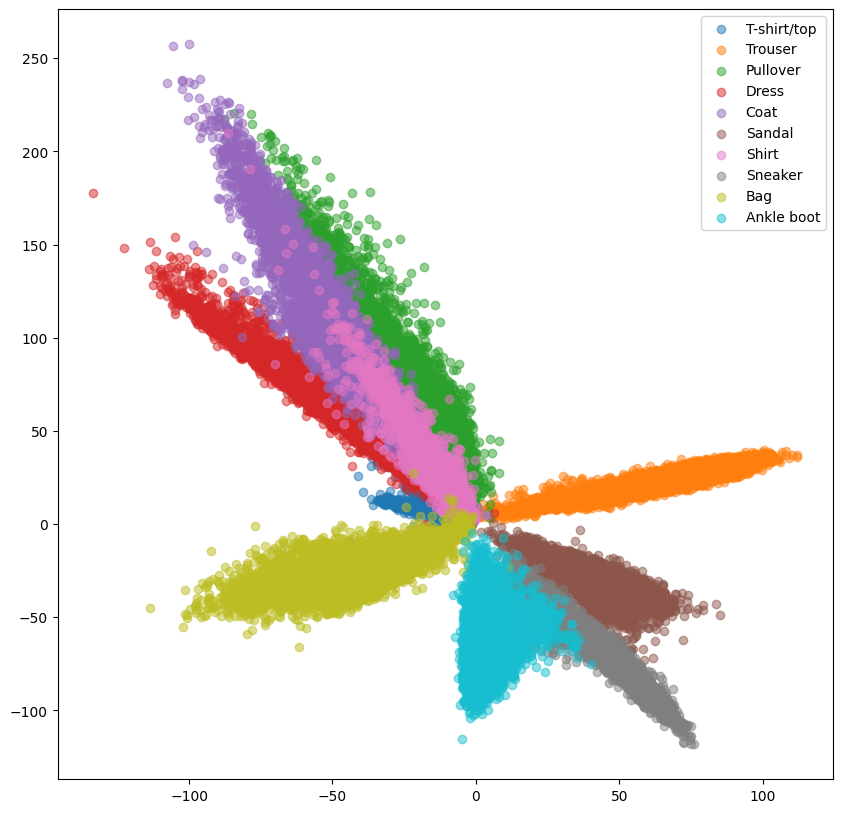

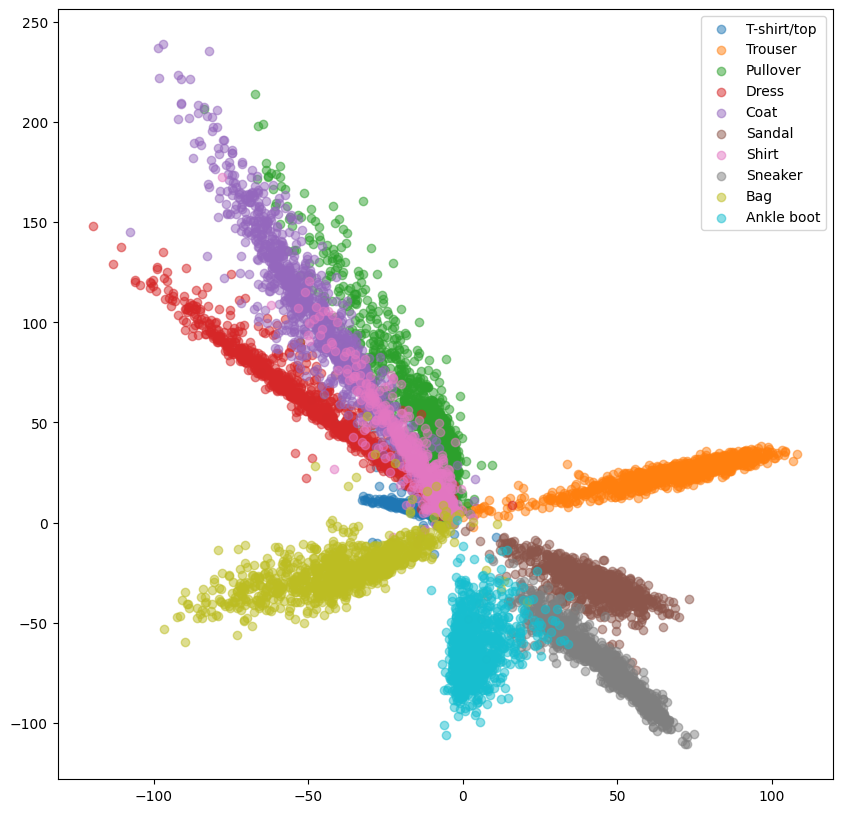

In [11]:
train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_baseline, train_labels_baseline)
val_embeddings_baseline, val_labels_baseline = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_baseline, val_labels_baseline)

## Siamese Head

We will repeat the process with a siamese network, but in order to do that we need first to create a different dataset, that creates positive and negative pairs from the original dataset. The pairs will be generated on the fly, randomly, while training. While testing, we will maintain the same pairs always so that comparisons would make sense.

Note that here we just aim to create valid pairs, we do not do any mining (we do not care if they are easy, semi-hard or hard).

In [13]:
class SiameseDataset(Dataset):
    """
    Train: For each sample creates randomly a positive or a negative pair
    Test: Creates fixed pairs for testing
    """

    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset

        self.train = self.mnist_dataset.train
        self.transform = self.mnist_dataset.transform

        self.labels = self.mnist_dataset.targets
        self.data = self.mnist_dataset.data
        self.labels_set = set(self.labels.numpy())
        self.label_to_indices = {label: np.where(self.labels.numpy() == label)[0]
                                 for label in self.labels_set}

        if not self.train:
            # generate fixed pairs for testing once at initialisation
            random_state = np.random.RandomState(29) # Fix random seed for testing

            positive_pairs = [[i,
                               random_state.choice(self.label_to_indices[self.labels[i].item()]),
                               1]
                              for i in range(0, len(self.data), 2)]

            negative_pairs = [[i,
                               random_state.choice(self.label_to_indices[
                                                       np.random.choice(
                                                           list(self.labels_set - set([self.labels[i].item()]))
                                                       )
                                                   ]),
                               0]
                              for i in range(1, len(self.data), 2)]
            self.test_pairs = positive_pairs + negative_pairs

    def __getitem__(self, index):
        if self.train:
            # Generate a positive or negative pair on the fly
            target = np.random.randint(0, 2) # randomly select positive or negative
            img1, label1 = self.data[index], self.labels[index].item()
            if target == 1: # Generate a POSITIVE pair
                siamese_index = index
                while siamese_index == index: # Make sure we do not use ourself as the positive pair
                    siamese_index = np.random.choice(self.label_to_indices[label1])
            else: # Generate a NEGATIVE pair
                siamese_label = np.random.choice(list(self.labels_set - set([label1])))
                siamese_index = np.random.choice(self.label_to_indices[siamese_label])
            img2 = self.data[siamese_index]
        else:
            # Just retrieve the pair from the saved test pairs we generated at init
            img1 = self.data[self.test_pairs[index][0]]
            img2 = self.data[self.test_pairs[index][1]]
            target = self.test_pairs[index][2]

        # Get a PIL image to pass through transform
        img1 = Image.fromarray(img1.numpy(), mode='L')
        img2 = Image.fromarray(img2.numpy(), mode='L')
        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        return img1, img2, target


    def __len__(self):
        return len(self.mnist_dataset)

Now we are ready to define our siamese net which just takes in one training sample (which now comprises a pair of images) and embeds them using our embedding function. It returns the two embeddings.

In [14]:
class SiameseNet(nn.Module):
    def __init__(self, embedding_net):
        super(SiameseNet, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, x1, x2):
        output1 = self.embedding_net(x1)
        output2 = self.embedding_net(x2)
        return output1, output2

    def get_embedding(self, x):
        return self.embedding_net(x)

The next thing to do is to define our loss function for the case of the siamese. In this case, we need a function that takes as input TWO vectors and one target that indicates if they are supposed to be a positive pair, or a negative pair, and implements the function:

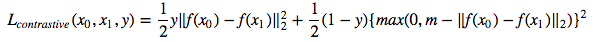

In [15]:
class ContrastiveLoss(nn.Module):
    """
    Max-Margin Contrastive loss
    Takes embeddings of two samples and a target label == 1 if samples are from the same class and label == 0 otherwise
    """

    def __init__(self, margin):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.eps = 1e-9

    def forward(self, output1, output2, target, size_average=True):
        distances = (output2 - output1).pow(2).sum(1)  # squared distances
        # losses = 0.5 * (target.float() * distances + (1 - target).float() * max(0, self.margin - (distances + self.eps).sqrt()).pow(2)) equivalent to
        losses = 0.5 * (target.float() * distances + (1 - target).float() * F.relu(self.margin - (distances + self.eps).sqrt()).pow(2))
        return losses.mean() if size_average else losses.sum()

We will also redefine the training and validation loops, as now the data loader gives us 2 samples and the loss function expects 2 samples.

In [16]:
def train_epoch_siamese(train_loader, model, criterion, optimizer):

    model.train()
    losses = []
    total_loss = 0
    correct = 0

    for batch_idx, (data1, data2, target) in enumerate(train_loader):
        target = target.to(device)
        data1 = data1.to(device)
        data2 = data2.to(device)

        optimizer.zero_grad()

        output1, output2 = model(data1, data2)

        # The loss is the only thing we can report here
        loss = criterion(output1, output2, target)
        losses.append(loss.item())
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        if batch_idx % 20 == 0:
            print("Iteration {}: Loss = {}".format(batch_idx, loss.item()))

    total_loss /= (batch_idx + 1)
    return total_loss

@torch.no_grad()
def test_epoch_siamese(val_loader, model, criterion):

    model.eval()
    val_loss = 0
    correct = 0

    for batch_idx, (data1, data2, target) in enumerate(val_loader):
        target = target.to(device)
        data1 = data1.to(device)
        data2 = data2.to(device)

        output1, output2 = model(data1, data2)

        loss = criterion(output1, output2, target)
        val_loss += loss.item()

    return val_loss

In [17]:
siamese_train_dataset = SiameseDataset(train_dataset) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseDataset(test_dataset)   # Note that the train datasets has self.train == True, and the test has self.train == False

batch_size = 256
siamese_train_loader = DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True)
siamese_test_loader = DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False)

margin = 1.

embedding_net = EmbeddingNet()
model = SiameseNet(embedding_net)
model.to(device)

criterion = ContrastiveLoss(margin)

lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)

In [18]:
n_epochs = 10 # Do 10 epochs
for epoch in range(n_epochs):

        # Train stage
        train_loss = train_epoch_siamese(siamese_train_loader, model, criterion, optimizer)
        scheduler.step()

        message = 'Epoch: {}/{}. Train set: Average loss: {:.4f}'.format(epoch + 1, n_epochs, train_loss)

        # Validation stage
        val_loss = test_epoch_siamese(siamese_test_loader, model, criterion)
        val_loss /= len(siamese_test_loader)

        message += '\nEpoch: {}/{}. Validation set: Average loss: {:.4f}'.format(epoch + 1, n_epochs, val_loss)

        print(message)

Iteration 0: Loss = 0.2575904428958893
Iteration 20: Loss = 0.06319352984428406
Iteration 40: Loss = 0.06978625059127808
Iteration 60: Loss = 0.042719729244709015
Iteration 80: Loss = 0.03971303254365921
Iteration 100: Loss = 0.05094529315829277
Iteration 120: Loss = 0.039136212319135666
Iteration 140: Loss = 0.05091070383787155
Iteration 160: Loss = 0.04130633920431137
Iteration 180: Loss = 0.04415697604417801
Iteration 200: Loss = 0.043873704969882965
Iteration 220: Loss = 0.04644794389605522
Epoch: 1/10. Train set: Average loss: 0.0516
Epoch: 1/10. Validation set: Average loss: 0.0433
Iteration 0: Loss = 0.04119081050157547
Iteration 20: Loss = 0.052273496985435486
Iteration 40: Loss = 0.03495895862579346
Iteration 60: Loss = 0.044556476175785065
Iteration 80: Loss = 0.043782614171504974
Iteration 100: Loss = 0.041841305792331696
Iteration 120: Loss = 0.032607629895210266
Iteration 140: Loss = 0.047681912779808044
Iteration 160: Loss = 0.03264343738555908
Iteration 180: Loss = 0.030

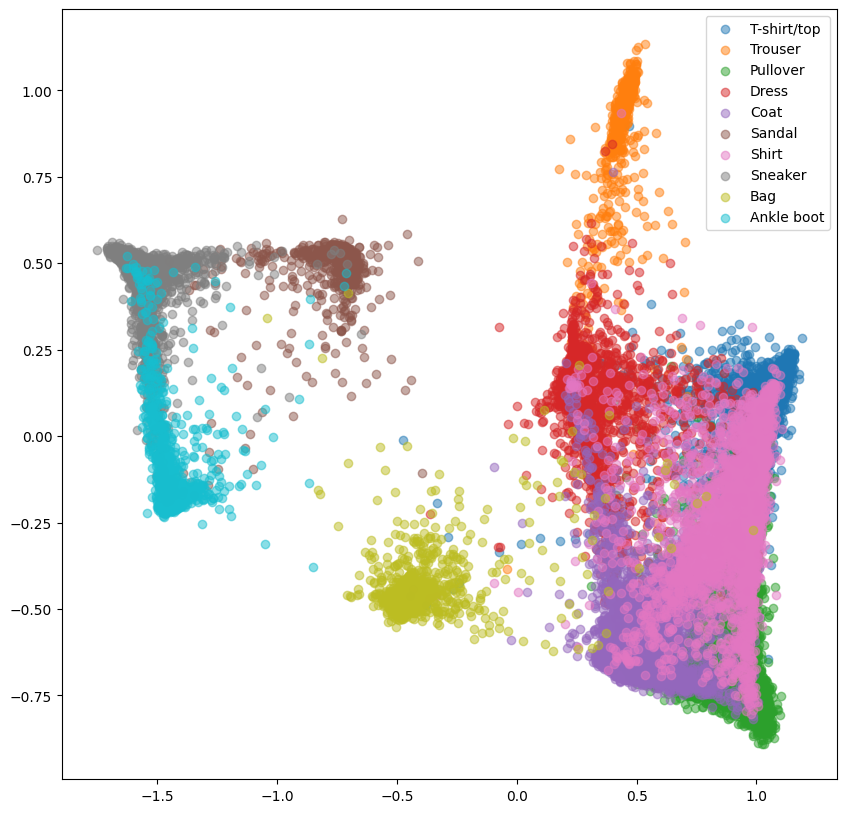

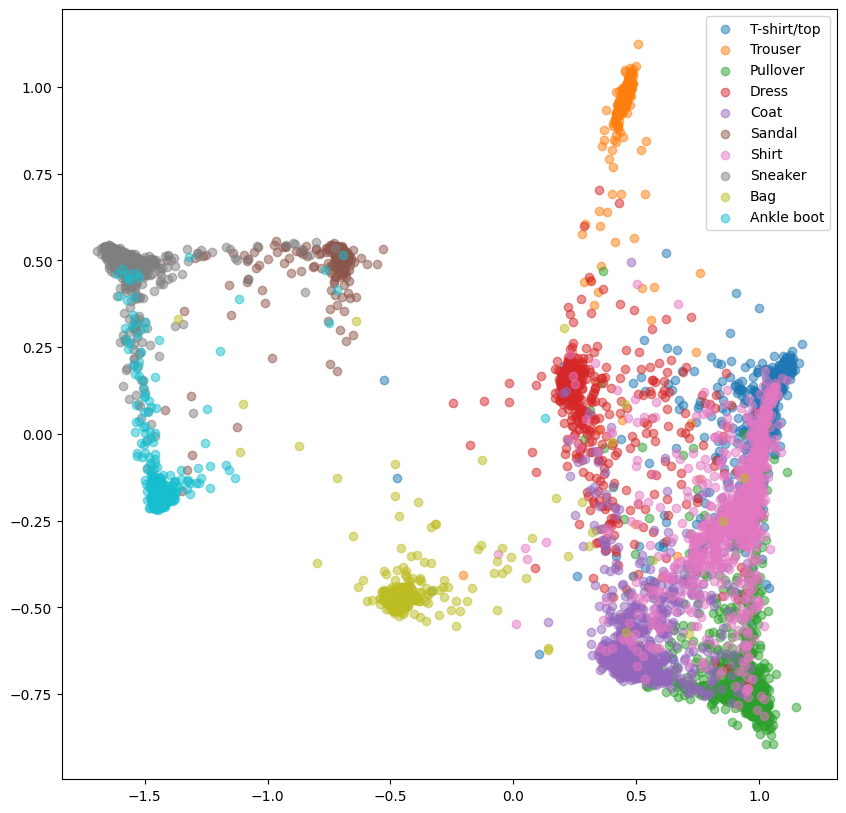

In [19]:
train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_baseline, train_labels_baseline)
val_embeddings_baseline, val_labels_baseline = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_baseline, val_labels_baseline)

There are couple of problems with siamese and (triplet) networks the way we have implemented them up to this point.

- The number of possible pairs/triplets grows quadratically/cubically with the number of examples. It's infeasible to process them all
- We generate pairs/triplets randomly. As the training continues, more and more pairs/triplets are easy to deal with (their loss value is very small or even 0), preventing the network from training. We need to provide the network with hard examples.
- Each image that is fed to the network is used only for computation of contrastive/triplet loss for only one pair/triplet. The computation is somewhat wasted; once the embedding is computed, it could be reused for many pairs/triplets.

To deal with that efficiently, we'll feed a network with standard mini-batches as we did for classification. The loss function will be responsible for selection of hard pairs and triplets within mini-batch. In this case, if we feed the network with 16 images per 10 classes, we can process up to $159*160/2 = 12720$ pairs and $10*16*15/2*(9*16) = 172800$ triplets, compared to 80 pairs and 53 triplets in previous implementation.

## Triplet Loss

We will now train FashionMNIST using a semi-hard Triplet Mining strategy, and visualize the embeddings.

We will not implement any miner, loss or distance function by hand. Instead we will use [The Pytorch Metric Learning Library](https://github.com/KevinMusgrave/pytorch-metric-learning) (installed in the cell below) which implements everything we need.

Check its [docs](https://kevinmusgrave.github.io/pytorch-metric-learning/) so that you get an idea of how to use it.

Install the required packages below. Uncomment the corresponding cell to use the package manager that suits your installation (for Google Colab, that would be pip).

In [ ]:
#%conda install -y -c metric-learning pytorch-metric-learning=2.1.1
#%conda install -y -c conda-forge faiss-gpu=1.6.5

In [ ]:
%pip install pytorch-metric-learning faiss-gpu

In [ ]:
from pytorch_metric_learning import losses, miners, distances, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

We will redefine our training and test loops to use this library. The idea is that first we embedd all the data inside our batch. Then we will ask a *Miner* to find good triplets. The list of triplets (a list of tuples with indices) will be passed on to the loss function, that will calculate the loss based on them.

In [ ]:
def train(model, loss_func, mining_func, train_loader, optimizer, epoch):
    model.train()
    total_loss = 0

    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        embeddings = model(data)

        indices_tuple = mining_func(embeddings, labels)
        loss = loss_func(embeddings, labels, indices_tuple)

        total_loss += loss.item()
        loss.backward()

        optimizer.step()
        if batch_idx % 20 == 0:
            print("Epoch {} Iteration {}: Loss = {}, Number of mined triplets = {}".format(epoch, batch_idx, loss, mining_func.num_triplets))

    return total_loss / (batch_idx + 1)

def get_all_embeddings(dataset, model):
    tester = testers.BaseTester(dataloader_num_workers=2)
    return tester.get_all_embeddings(dataset, model)

def test(train_set, test_set, model, accuracy_calculator):
    model.eval()
    train_embeddings, train_labels = get_all_embeddings(train_set, model)
    test_embeddings, test_labels = get_all_embeddings(test_set, model)

    print("Computing accuracy")
    accuracies = accuracy_calculator.get_accuracy(query = train_embeddings, reference = test_embeddings, query_labels = train_labels, reference_labels = test_labels)

    print("Test set accuracy (Precision@1) = {}".format(accuracies["precision_at_1"]))


We now need to define our miner. Here we will use a `TripletMarginMiner` and cosine similarity to measure the distance between embeddings. We will also use an "accuracy" calculator. The actual metric we will be using is a *precision at 1*, which is just a fancy way to ask whether the 1st nearest neighbour of each sample is of the same class.

https://kevinmusgrave.github.io/pytorch-metric-learning/accuracy_calculation/

In [ ]:
distance = distances.CosineSimilarity()
mining_func = miners.TripletMarginMiner(margin = 0.2, distance=distance, type_of_triplets="all") #All useful ones
accuracy_calculator = AccuracyCalculator(include=("precision_at_1",), k = 1)

Define the datasets, dataloaders, and the model to use. The model we will use here is just the embedding net on its own.

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

model = EmbeddingNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_func = losses.TripletMarginLoss(margin=1., distance = distance)

In [ ]:
num_epochs = 10
loss_evolution = []

for epoch in range(1, num_epochs + 1):
    loss = train(model, loss_func, mining_func, train_loader, optimizer, epoch)
    loss_evolution.append(loss)
    test(train_dataset, test_dataset, model, accuracy_calculator)

plt.plot(loss_evolution)
plt.show()

In [ ]:
train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_baseline, train_labels_baseline)
val_embeddings_baseline, val_labels_baseline = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_baseline, val_labels_baseline)

## Better Mining

<br>
<span style="color:blue">

**Exercise 1**: Explain the difference between semi-hard, easy and hard triplets. Try training with each type of triplets mentioned above separately and comment on the effect they have on training, using loss curves and other evidence you find necessary.
    
</span>

In [ ]:
#Your Code Here


<br>
<span style="color:blue">

**Exercise 2**: Read the documentation of the PyTorch Metric Learning library and try a couple of different mining strategies, distances, margins and loss functions.
    
</span>

In [ ]:
# Your Code Here


## Better embeddings

<br>
<span style="color:blue">

**Exercise 3**: Train a new (preferably more powerful) network with a 128-dimensional embedding, visualize the embedding using T-SNE.

We will use the T-SNE library from sklearn, you can see the [documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) for info on how to use it.

Report accuracies for both networks (the one with 2-dimensional embeddings and this one) and compare the visualizations of both embeddings.

Explanation of T-SNE [here](https://distill.pub/2016/misread-tsne/)

**Important T-SNE is rather slow so dont visualize the embeddings for every sample. Randomly select a few hundreds**

</span>

In [ ]:
# Your Code Here
